#            Sentiment Analysis on Anime Reviews 

* ## 0 Introduction 
    * ### 0.1 Import Libraries
    * ### 0.2 Loading the Database 

* ## 1 Exploratory Data Analysis 
    * ### 1.1 Data Exploration 
        * #### 1.1.1 Rating Frequency Table
        * #### 1.1.2 Word Cloud 
    * ### 1.2 Data Cleaning 
    * ### 1.3 Data Split - only get rTrain
    * ### 1.4 Word Frequency Table 
    * ### 1.5  Import Sentiment Weights 

* ## 2 Train Models 
    * ### 2.1 Logistic Regression 
    * ### 2.2 Gaussian Naive Bayes 
    * ### 2.3 Random Forests 

* ## 3 Model Selection 
        * Cross Validatioin 
        * print skm_conf_mat

* ## 4 Prediction on Random Forests 

## 0. Introduction 

* Question: 
How we can use Sentiment Analysis on comments to further predict viewers' ratings? 

* Source: 
A Japanese anime, from Chinese viewing website called bilibili.com, which went IPO in NY Exchange as ticker (BILI). The reviews are scrapped from the website using JSON and till the end of the date of May 6, 2019. 

* Deliverables: cvs.file on predicting Ratings 

## Note: 
Test data is split half (train/test) and then 70-30, containing 2258 comments. 

### 0.1 Import Libraries 

In [1]:
import os 
import sys 
import re

import scipy
import numpy as np
import pandas as pd
import jieba.analyse
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# import sklearn modules 
import sklearn.metrics as skm
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as skm_conf_mat
from collections import Counter
from collections import defaultdict

### 0.2 Loading the Dataset

In [2]:
datas = pd.read_csv("./bilibilib_gongzuoxibao.csv", sep = ",")

## 1. Exploratory Data Analysis 
### 1.1. Data Exploration 

In [3]:
colnames = datas.columns
print(colnames) # author, score, disliked, likes, liked, ctime, score.1, content, last_ex_index, cursor, date

Index(['author', 'score', 'disliked', 'likes', 'liked', 'ctime', 'content',
       'last_ep_index', 'cursor', 'date'],
      dtype='object')


In [4]:
datas.shape

(19063, 10)

In [5]:
datas.head()

,author,score,disliked,likes,liked,ctime,content,last_ep_index,cursor,date
0,緖山まひろ,10,0,9981,0,1530982477,我有个想法，动物体内的细胞会不会是兽耳呢d(ŐдŐ๑),0,77395314810369,2018-07-07 16:54:37
1,onlylove丶亚丝娜,10,0,1,0,1557139155,题材新颖,0,77395314810369,2019-05-06 10:39:15
2,AKAHANE_铃木羽,10,0,3,0,1556947242,坐等第二季！！表白白细胞∠( ᐛ 」∠)＿,0,77395314810369,2019-05-04 05:20:42
3,妖怪退散,10,0,0,0,1557182714,好看，推荐,0,77395314810369,2019-05-06 22:45:14
4,受虎大王,10,0,0,0,1557118709,涨知识,0,77395314810369,2019-05-06 04:58:29


#### 1.1.1 Rating Frequency Table

In [6]:
datas['score'].value_counts()

10    17480
8       933
6       292
2       272
4        86
Name: score, dtype: int64

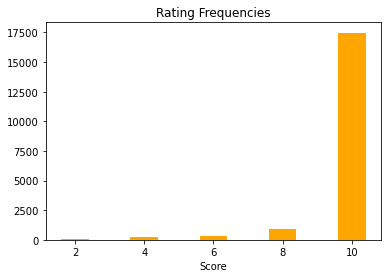

In [7]:
x = list(sorted(datas['score'].unique()))
y = list(datas['score'].value_counts())[::-1]
plt.bar(x,y, color='orange')
plt.xlabel('Score')
plt.ylabel('')
plt.title('Rating Frequencies')
plt.show()

In [8]:
#%% Content Analysis 
texts = ';'.join(datas['content'].tolist())
cut_text = " ".join(jieba.cut(texts))
# TF_IDF
keywords = jieba.analyse.extract_tags(cut_text, topK=100, withWeight=True, allowPOS=('a','e','n','nr','ns'))
text_cloud = dict(keywords)
###pd.DataFrame(keywords).to_excel('TF_IDF关键词前100.xlsx')

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/xs/nq7vm8r13hz0xx2101tsfxlc0000gn/T/jieba.cache
Loading model cost 1.093 seconds.
Prefix dict has been built successfully.


In [9]:
# Remove all punctuation and expression marks 
temp =  "\\【.*?】+|\\《.*?》+|\\#.*?#+|[.!/_,$&%^*()<>+""'?@|:~{}#]+|[——！\\\，。=？、：“”‘’￥……（）《》【】]"
cut_text = re.sub(pattern = temp, repl = "", string = cut_text)

#### cannot open Word Cloud picture 

### 1.2. Data Cleaning 

In [10]:
del datas['ctime']
del datas['cursor']
del datas['liked']
del datas['disliked']
del datas['likes']
del datas['last_ep_index']
pd.isnull(datas).astype(int).aggregate(sum, axis = 0)

author     0
score      0
content    0
date       0
dtype: int64

### 1.3. Data Split

In [11]:
perfect = datas[datas.score == 10]
imperfect = datas[datas.score != 10]
perfect_sample = perfect.sample(n = 1583, random_state = 1 )
new_data = pd.concat([perfect_sample, imperfect], axis = 0)

features = new_data['content']
labels = new_data['score']

In [12]:
rTrain, rTest, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state=42)
# let's understand up a bit the data
## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(rTrain.shape), 
      #"\nValidation set: \t{}".format(rValidation.shape),
      "\nTest set: \t\t{}".format(rTest.shape))

			Feature Shapes:
Train set: 		(2216,) 
Test set: 		(950,)


### 1.4. Frequency Table for Top 100 

In [13]:
texts = '\n'.join(rTrain.tolist())
#cut_text = jieba.lcut(texts)
cut_text = "".join(jieba.cut(texts))
cut_text = re.sub(pattern = temp, repl = "", string = cut_text)

keyword = jieba.analyse.extract_tags(cut_text, topK=100, allowPOS=('a','e','n','nr','ns'))  # list
cut_text = cut_text.split('\n')
keyword

['血小板',
 '细胞',
 '剧情',
 '不错',
 '有趣',
 '感觉',
 '动画',
 '啊啊啊',
 '生物',
 '身体',
 '动漫',
 '番剧',
 '新颖',
 '有点',
 '无聊',
 '白细胞',
 '红细胞',
 '很棒',
 '题材',
 '白血球',
 '画风',
 '香菜',
 '脑洞',
 '癌细胞',
 '优秀',
 '作品',
 '拟人化',
 '意义',
 '单身',
 '漫画',
 '老婆',
 '热血',
 '很好',
 '弹幕',
 '陪伴',
 '硬核',
 '赛高',
 '超棒',
 '声优',
 '一般',
 '会员',
 '安利',
 '时候',
 '套路',
 '作画',
 '故事',
 '科普性',
 '文科生',
 '理科生',
 '卡哇伊',
 '人物',
 '棒棒',
 '评分',
 '细菌',
 '人体',
 '大家',
 '霸权',
 '红血球',
 '内容',
 '新意',
 '科普知识',
 '总体',
 '亮点',
 '白哥',
 '情节',
 '良心',
 '谢谢',
 '地方',
 '生物学',
 '角色',
 '医学生',
 '迷路',
 '个人',
 '方式',
 '路痴',
 '轻松',
 '画面',
 '老少皆宜',
 '学生',
 '好好看',
 '兴趣',
 '节奏',
 '方面',
 '完美',
 '简单',
 '拟人',
 '尴尬',
 '精良',
 '一星',
 '作者',
 '真棒',
 '姿势',
 '厉害',
 '帅气',
 '国漫',
 '制作组',
 '女主',
 '主人',
 '整体',
 '生病']

In [14]:
cutlist = []

for i in range(0, len(cut_text)):
    cut_dic = defaultdict(int) 
    comment = cut_text[i]
    comment_cut = jieba.lcut(comment)
    for word in comment_cut: # word freq for every comment 
        if word in keyword:
            cut_dic[word] += 1  
    order = sorted(cut_dic.items(),key = lambda x:x[1],reverse = True) # word freq in descending order
    #print(order)
 
    myresult = "" 
    for j in range(0,len(order)): 
        result = order[j][0]+ "-" + str(order[j][1])
        myresult = myresult + " " + result  
    cutlist.append(myresult)
#print(cutlist)

In [15]:
word_freqs = []
for raw in cutlist:
    word_freq = {}
    for word_freq_raw in raw.split():
        index = word_freq_raw.find('-')
        word = word_freq_raw[:index]
        freq = int(word_freq_raw[index + 1])
        word_freq[word] = freq
    word_freqs.append(word_freq)
    
matrix = []
for word_freq in word_freqs:
    row = []
    for word in keyword:
        if word in word_freq:
            row.append(word_freq[word])
        else:
            row.append(0)
    matrix.append(row)
#print(matrix)
matrix = np.array(matrix)

### 1.5. Import Sentiment Weights 
> X_rTrain

In [16]:
grade1 = np.array([0.1
,0
,0
,0.7
,0.8
,0.1
,0
,0.3
,0
,0
,0
,0
,0.6
,0.1
,-1
,0
,0
,1
,0
,0
,0
,0.5
,-0.3
,-0.1
,0.8
,0
,0.4
,0
,0
,0
,0.6
,0.6
,0.8
,0
,0.6
,0.4
,0.6
,1
,0
,-0.7
,0
,0.9
,0
,-0.2
,0
,0
,0
,0
,0
,0.7
,0
,1
,0
,0
,0
,0
,-0.2
,0
,0
,0.6
,0.1
,0
,0.6
,0.3
,0
,0.7
,0.7
,0
,0
,0
,0
,0
,0
,0
,0
,0.4
,0
,0.6
,0
,1
,0.6
,0
,0
,1
,0.4
,0.2
,-1
,0.8
,-1
,0
,1
,0
,0.9
,0.7
,-0.3
,0
,0.2
,0
,0
,0])

In [17]:
X = np.array(matrix) * grade1

## 2. Train Model 
### 2.1. Logistic Regression

In [18]:
# import Logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X, y_train)
clf.score(X, y_train)

0.5342960288808665

In [19]:
np.unique(clf.predict(X))

array([ 2,  6,  8, 10])

### 2.2 Gaussian Naive Bayes

In [20]:
#Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(X, y_train)
gnb.score(X,y_train)

0.08664259927797834

In [21]:
np.unique(gnb.predict(X))

array([ 2,  4,  6,  8, 10])

### 2.3 Random Forests 

In [22]:
from sklearn.ensemble import RandomForestClassifier as RFClass
model_rf = RFClass(n_estimators = 100, max_depth=5, random_state=2019)
model_rf.fit(X, y_train)
model_rf.score(X, y_train)

0.5234657039711191

In [23]:
np.unique(gnb.predict(X))

array([ 2,  4,  6,  8, 10])

## 3. Model Selection
> Import rTest

In [24]:
texts = '\n'.join(rTest.tolist())
#cut_text = jieba.lcut(texts)
cut_text = "".join(jieba.cut(texts))
cut_text = re.sub(pattern = temp, repl = "", string = cut_text)

keyword = jieba.analyse.extract_tags(cut_text, topK=100, allowPOS=('a','e','n','nr','ns'))  # list
cut_text = cut_text.split('\n')
keyword

['血小板',
 '细胞',
 '剧情',
 '不错',
 '啊啊啊',
 '动画',
 '生物',
 '有趣',
 '香菜',
 '身体',
 '有点',
 '感觉',
 '白细胞',
 '动漫',
 '很棒',
 '无聊',
 '声优',
 '红细胞',
 '题材',
 '拟人化',
 '番剧',
 '新颖',
 '白血球',
 '赛高',
 '作品',
 '意义',
 '超棒',
 '漫画',
 '很好',
 '癌细胞',
 '会员',
 '评分',
 '女主',
 '时候',
 '作画',
 '弹幕',
 '陪伴',
 '老婆',
 '肥宅',
 '细菌',
 '人物',
 '人体',
 '学生',
 '红血球',
 '硬核',
 '棒棒',
 '血腥',
 '配音',
 '一般',
 '安利',
 '枯燥',
 '轻松',
 '科普知识',
 '套路',
 '脑洞',
 '新意',
 '画风',
 '拟人',
 '单身',
 '大家',
 '个人',
 '故事',
 '看点',
 '科普性',
 '兴趣',
 '意思',
 '严谨',
 '恶心',
 '形象',
 '医学生',
 '佳作',
 '阵容',
 '文科生',
 '虚高',
 '花泽',
 '番会',
 '珍惜',
 '老套',
 '节奏',
 '树突',
 '贫穷',
 '场景',
 '谢谢你们',
 '用心',
 '老师',
 '精彩',
 '观感',
 '刻画',
 '理由',
 '内容',
 '现实',
 '亮点',
 '豪华',
 '谢谢',
 '观众',
 '角色',
 '精良',
 '科学',
 '卡哇伊',
 '美化']

In [25]:
cutlist = []

for i in range(0, len(cut_text)):
    cut_dic = defaultdict(int) 
    comment = cut_text[i]
    comment_cut = jieba.lcut(comment)
    for word in comment_cut: # word freq for every comment 
        if word in keyword:
            cut_dic[word] += 1  
    order = sorted(cut_dic.items(),key = lambda x:x[1],reverse = True) # word freq in descending order
    #print(order)
 
    myresult = "" 
    for j in range(0,len(order)): 
        result = order[j][0]+ "-" + str(order[j][1])
        myresult = myresult + " " + result  
    cutlist.append(myresult)
#print(cutlist)

In [26]:
word_freqs = []
for raw in cutlist:
    word_freq = {}
    for word_freq_raw in raw.split():
        index = word_freq_raw.find('-')
        word = word_freq_raw[:index]
        freq = int(word_freq_raw[index + 1])
        word_freq[word] = freq
    word_freqs.append(word_freq)
    
matrix = []
for word_freq in word_freqs:
    row = []
    for word in keyword:
        if word in word_freq:
            row.append(word_freq[word])
        else:
            row.append(0)
    matrix.append(row)
#print(matrix)
matrix = np.array(matrix)

In [27]:
grade2 = np.array([0.1
,0
,0
,0.7
,0.3
,0
,0
,0.8
,0.5
,0
,0.1
,0.1
,0
,0
,1
,-1
,0
,0
,0
,0.4
,0
,0.6
,0
,0.6
,0
,0
,1
,0
,0.8
,-0.1
,0
,0
,0.4
,0
,0
,0
,0.6
,0.6
,-0.4
,0
,0
,0
,0
,0
,0.4
,1
,-0.6
,0
,-0.7
,0.9
,-1
,0.4
,0.1
,-0.2
,-0.3
,0.6
,0
,0.2
,0
,0
,0
,0
,0.2
,0
,0.6
,0
,0.5
,-1
,0
,0
,0.9
,0
,0
,-0.6
,0.1
,0
,0.4
,-0.8
,0
,0
,-0.3
,0
,0.7
,0.5
,0
,0.8
,0
,0
,0
,0
,-0.2
,0.6
,0.5
,0.7
,0
,0
,0.8
,0.5
,0.7
,-0.4])

In [28]:
xTest = np.array(matrix) * grade2
xTest.shape

(950, 100)

> function confusion matrix

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.show()

np.set_printoptions(precision = 2)

### Log prediction

In [30]:
clf_proba = clf.predict_proba(xTest)   # predict probability 
clf_pred = clf.predict(xTest)   # prediction result
clf.score(xTest, y_test)

0.5305263157894737

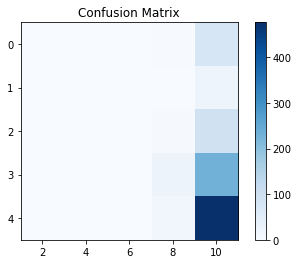

In [31]:
clf_cm = skm_conf_mat(y_test, clf_pred)
plot_confusion_matrix(clf_cm, classes = list(sorted(y_train.unique())), title = 'Confusion Matrix')

### Cross Validation

In [32]:
clfcv = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X, y_train)
clfcv.score(X, y_train)

/Users/sherrytp/opt/anaconda3/envs/ml4t/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sherrytp/opt/anaconda3/envs/ml4t/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

0.5487364620938628

In [33]:
clfcv_proba = clfcv.predict_proba(xTest)
clfcv_pred = clfcv.predict(xTest)
clfcv.score(xTest, y_test)

0.5242105263157895

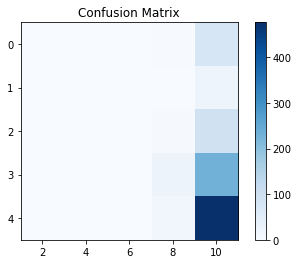

In [34]:
clfcv_cm = skm_conf_mat(y_test, clf_pred)
plot_confusion_matrix(clfcv_cm, classes = list(sorted(datas['score'].unique())), title = 'Confusion Matrix')

### RF

In [35]:
rf_proba = model_rf.predict_proba(xTest)
rf_pred = model_rf.predict(xTest)
model_rf.score(xTest, y_test)

0.5189473684210526

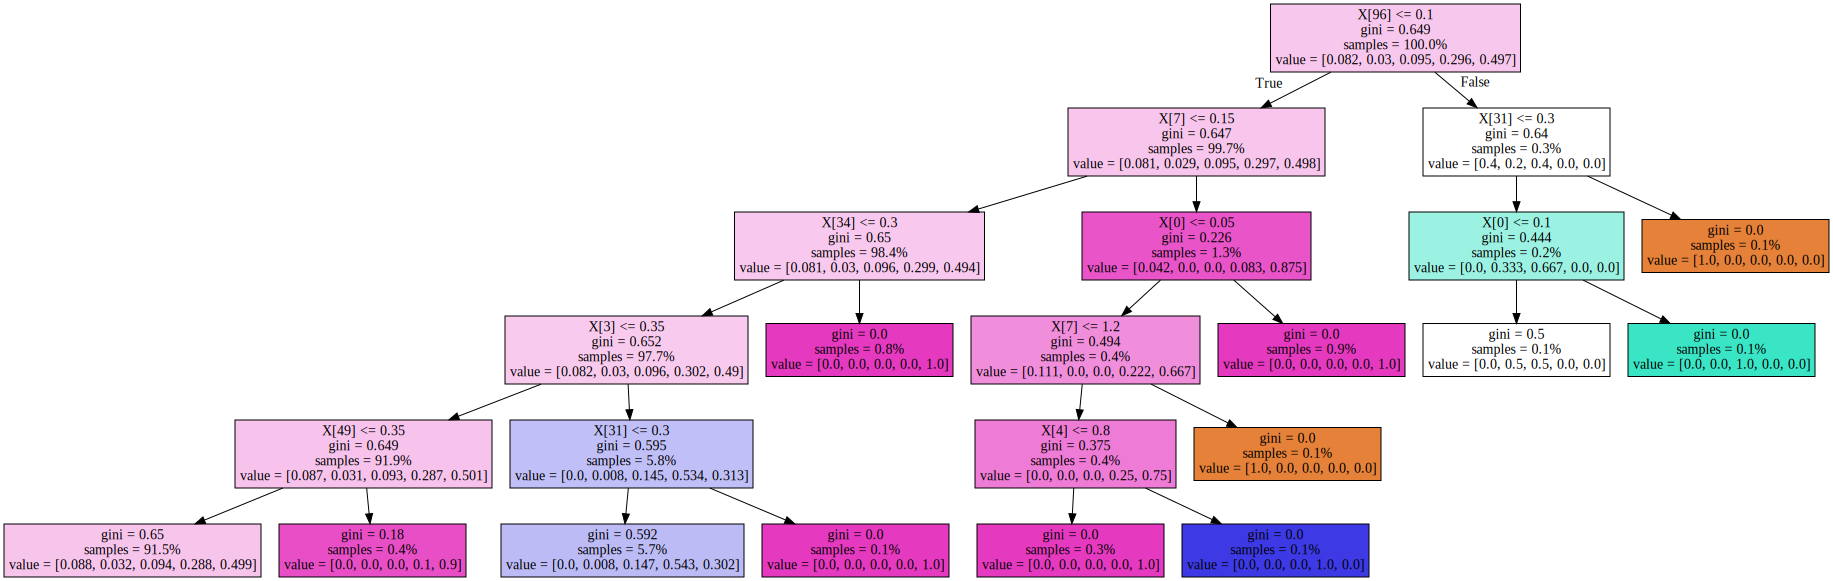

In [36]:
# Tree Plot
from graphviz import Source
from sklearn import tree as treemodule
Source(treemodule.export_graphviz(
        model_rf.estimators_[1]
        , out_file=None
        , filled = True
        , proportion = True #@@ try False and understand the differences
        )
)

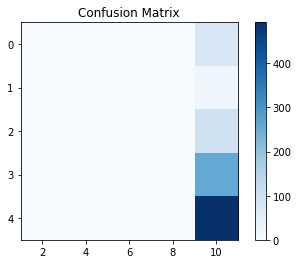

In [37]:
rf_cm = skm_conf_mat(y_test, rf_pred)
plot_confusion_matrix(rf_cm, classes = list(sorted(datas['score'].unique())), title = 'Confusion Matrix')

## 4. Prediction Print on RF

In [38]:
rf_pred = pd.DataFrame(rf_pred)
rf_pred.to_csv("Predictions on Ratings.csv")

* ## 3 Model Selection REVISED
    * ### 3.1 Group Ratings by very high(10), high(8), and others(2-6) TO (4) 

In [39]:
#score = (new_data.score == 2)|(new_data.score == 6)
new_data.loc[new_data.score == 6, 'score'] = 4
new_data.loc[new_data.score == 2, 'score'] = 4

In [40]:
features = new_data['content']
labels = new_data['score']

new_data['score'].value_counts()

10    1583
8      933
4      650
Name: score, dtype: int64

In [41]:
rTrain, rTest, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state=42)
# let's understand up a bit the data
## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(rTrain.shape), 
      #"\nValidation set: \t{}".format(rValidation.shape),
      "\nTest set: \t\t{}".format(rTest.shape))

			Feature Shapes:
Train set: 		(2216,) 
Test set: 		(950,)


* rTrain

In [42]:
texts = '\n'.join(rTrain.tolist())
#cut_text = jieba.lcut(texts)
cut_text = "".join(jieba.cut(texts))
cut_text = re.sub(pattern = temp, repl = "", string = cut_text)

keyword = jieba.analyse.extract_tags(cut_text, topK=100, allowPOS=('a','e','n','nr','ns'))  # list
cut_text = cut_text.split('\n')
keyword

['血小板',
 '细胞',
 '剧情',
 '不错',
 '有趣',
 '感觉',
 '动画',
 '啊啊啊',
 '生物',
 '身体',
 '动漫',
 '番剧',
 '新颖',
 '有点',
 '无聊',
 '白细胞',
 '红细胞',
 '很棒',
 '题材',
 '白血球',
 '画风',
 '香菜',
 '脑洞',
 '癌细胞',
 '优秀',
 '作品',
 '拟人化',
 '意义',
 '单身',
 '漫画',
 '老婆',
 '热血',
 '很好',
 '弹幕',
 '陪伴',
 '硬核',
 '赛高',
 '超棒',
 '声优',
 '一般',
 '会员',
 '安利',
 '时候',
 '套路',
 '作画',
 '故事',
 '科普性',
 '文科生',
 '理科生',
 '卡哇伊',
 '人物',
 '棒棒',
 '评分',
 '细菌',
 '人体',
 '大家',
 '霸权',
 '红血球',
 '内容',
 '新意',
 '科普知识',
 '总体',
 '亮点',
 '白哥',
 '情节',
 '良心',
 '谢谢',
 '地方',
 '生物学',
 '角色',
 '医学生',
 '迷路',
 '个人',
 '方式',
 '路痴',
 '轻松',
 '画面',
 '老少皆宜',
 '学生',
 '好好看',
 '兴趣',
 '节奏',
 '方面',
 '完美',
 '简单',
 '拟人',
 '尴尬',
 '精良',
 '一星',
 '作者',
 '真棒',
 '姿势',
 '厉害',
 '帅气',
 '国漫',
 '制作组',
 '女主',
 '主人',
 '整体',
 '生病']

In [43]:
cutlist = []

for i in range(0, len(cut_text)):
    cut_dic = defaultdict(int) 
    comment = cut_text[i]
    comment_cut = jieba.lcut(comment)
    for word in comment_cut: # word freq for every comment 
        if word in keyword:
            cut_dic[word] += 1  
    order = sorted(cut_dic.items(),key = lambda x:x[1],reverse = True) # word freq in descending order
    #print(order)
 
    myresult = "" 
    for j in range(0,len(order)): 
        result = order[j][0]+ "-" + str(order[j][1])
        myresult = myresult + " " + result  
    cutlist.append(myresult)
#print(cutlist)

In [44]:
word_freqs = []
for raw in cutlist:
    word_freq = {}
    for word_freq_raw in raw.split():
        index = word_freq_raw.find('-')
        word = word_freq_raw[:index]
        freq = int(word_freq_raw[index + 1])
        word_freq[word] = freq
    word_freqs.append(word_freq)
    
matrix = []
for word_freq in word_freqs:
    row = []
    for word in keyword:
        if word in word_freq:
            row.append(word_freq[word])
        else:
            row.append(0)
    matrix.append(row)
#print(matrix)
matrix = np.array(matrix)

In [45]:
X = np.array(matrix) * grade1

* rTest 

In [46]:
texts = '\n'.join(rTest.tolist())
#cut_text = jieba.lcut(texts)
cut_text = "".join(jieba.cut(texts))
cut_text = re.sub(pattern = temp, repl = "", string = cut_text)

keyword = jieba.analyse.extract_tags(cut_text, topK=100, allowPOS=('a','e','n','nr','ns'))  # list
cut_text = cut_text.split('\n')
keyword

['血小板',
 '细胞',
 '剧情',
 '不错',
 '啊啊啊',
 '动画',
 '生物',
 '有趣',
 '香菜',
 '身体',
 '有点',
 '感觉',
 '白细胞',
 '动漫',
 '很棒',
 '无聊',
 '声优',
 '红细胞',
 '题材',
 '拟人化',
 '番剧',
 '新颖',
 '白血球',
 '赛高',
 '作品',
 '意义',
 '超棒',
 '漫画',
 '很好',
 '癌细胞',
 '会员',
 '评分',
 '女主',
 '时候',
 '作画',
 '弹幕',
 '陪伴',
 '老婆',
 '肥宅',
 '细菌',
 '人物',
 '人体',
 '学生',
 '红血球',
 '硬核',
 '棒棒',
 '血腥',
 '配音',
 '一般',
 '安利',
 '枯燥',
 '轻松',
 '科普知识',
 '套路',
 '脑洞',
 '新意',
 '画风',
 '拟人',
 '单身',
 '大家',
 '个人',
 '故事',
 '看点',
 '科普性',
 '兴趣',
 '意思',
 '严谨',
 '恶心',
 '形象',
 '医学生',
 '佳作',
 '阵容',
 '文科生',
 '虚高',
 '花泽',
 '番会',
 '珍惜',
 '老套',
 '节奏',
 '树突',
 '贫穷',
 '场景',
 '谢谢你们',
 '用心',
 '老师',
 '精彩',
 '观感',
 '刻画',
 '理由',
 '内容',
 '现实',
 '亮点',
 '豪华',
 '谢谢',
 '观众',
 '角色',
 '精良',
 '科学',
 '卡哇伊',
 '美化']

In [47]:
cutlist = []

for i in range(0, len(cut_text)):
    cut_dic = defaultdict(int) 
    comment = cut_text[i]
    comment_cut = jieba.lcut(comment)
    for word in comment_cut: # word freq for every comment 
        if word in keyword:
            cut_dic[word] += 1  
    order = sorted(cut_dic.items(),key = lambda x:x[1],reverse = True) # word freq in descending order
    #print(order)
 
    myresult = "" 
    for j in range(0,len(order)): 
        result = order[j][0]+ "-" + str(order[j][1])
        myresult = myresult + " " + result  
    cutlist.append(myresult)
#print(cutlist)

In [48]:
word_freqs = []
for raw in cutlist:
    word_freq = {}
    for word_freq_raw in raw.split():
        index = word_freq_raw.find('-')
        word = word_freq_raw[:index]
        freq = int(word_freq_raw[index + 1])
        word_freq[word] = freq
    word_freqs.append(word_freq)
    
matrix = []
for word_freq in word_freqs:
    row = []
    for word in keyword:
        if word in word_freq:
            row.append(word_freq[word])
        else:
            row.append(0)
    matrix.append(row)
#print(matrix)
matrix = np.array(matrix)

In [49]:
xTest = np.array(matrix) * grade2
xTest.shape

(950, 100)

In [50]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X, y_train)
clf.score(xTest, y_test)

0.5305263157894737

In [51]:
clfcv = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X, y_train)
clfcv.score(xTest, y_test)

/Users/sherrytp/opt/anaconda3/envs/ml4t/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sherrytp/opt/anaconda3/envs/ml4t/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

0.5263157894736842

In [52]:
gnb.fit(X, y_train)
gnb.score(xTest, y_test)

0.2326315789473684

In [53]:
model_rf.fit(X, y_train)
print(model_rf.score(X, y_train))
print(model_rf.score(xTest, y_test))

0.5437725631768953
0.5189473684210526


> Until now, we attempted multiple approaches to improve the accuracy rate of predicting corresponding scores on sentiment analysis. 

> 1. Importing different sets of sentiment weights
> 2. Lowering score dimensions to [4,8,10] rather [2,4,6,8,10] 